In [1]:
import os

os.chdir('drive/MyDrive/Colab Notebooks/Data Science Capstone Project/')

In [5]:
os.listdir()

['Sensor Fusion.ipynb',
 'clean.csv',
 'eval_model_1.ipynb',
 'Minutiae Sensor Prep.ipynb',
 'eval_model.py',
 'standardized_X_data.txt',
 'standardized_X_data.txt.npy',
 'standardized_X_data.npy',
 'LocalOutlierFactor.ipynb']

In [6]:
import pandas as pd
import numpy as np

In [7]:
dat = pd.read_csv('clean.csv')

In [8]:
dat.head()

,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
0,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0
1,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0
2,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0
3,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0
4,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0


In [ ]:
sub = dat.groupby('act').size().reset_index(name='Count').rename(columns={'act': 'Activity ID'})

In [ ]:
sub[['Activity ID','Activity','Count']]

KeyError: ignored

In [ ]:
dat.shape

(1412865, 8)

In [ ]:
sub['Activity'] = ['Downstairs', 'Upstairs', 'Walking', 'Jogging', 'Standing', 'Sitting']


In [ ]:
%run -i 'eval_model.py'

In [ ]:
os.listdir()

['Sensor Fusion.ipynb',
 'clean.csv',
 'eval_model_1.ipynb',
 'Minutiae Sensor Prep.ipynb',
 'eval_model.py']

In [ ]:
file_path = 'clean.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                 preprocess='standard', test_size=0.2,
                 random_state=42, epochs=10, batch_size=32,
                 save_model=True)

KeyboardInterrupt: ignored

In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

In [ ]:
dataset = pd.read_csv('clean.csv')
data_with_labels = np.c_[dataset.drop(columns=['act']).values,
                                pd.factorize(dataset['act'])[0]]

In [ ]:
def create_windows(data, window_size, step_size=1, with_label=True):
    """
    Create windows from a data matrix.
    data: The input data. The last column is assumed to be the label if with_label is True.
    window_size: The size of the sliding window.
    step_size: The step size of the sliding window.
    with_label: Whether the data contains a label column.
    """
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            # Take the mode (most common) label in the window as the label for this window
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

In [ ]:
X, y = create_windows(data_with_labels, window_size=50, step_size=1)

In [ ]:
y = pd.get_dummies(y).values

In [ ]:
X = np.array([StandardScaler().fit_transform(window) for window in X])

In [ ]:
np.save('standardized_X_data', X)

In [ ]:
X_loaded = np.load('standardized_X_data.npy')
X = np.expand_dims(X_loaded, axis=3)  # Add a channel dimension

In [ ]:
test_size = 0.2
random_state = None
task='multi_class'
window_size=50
step_size=1
target='act'
task='multi_class'
positive_label=None
preprocess='standard'
test_size=0.2
random_state=None
epochs=10
batch_size=32
save_model=False

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Build Model
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test

Epoch 1/10
28257/28257 [==============================] - 102s 3ms/step - loss: 0.2296 - accuracy: 0.9290 - val_loss: 0.1369 - val_accuracy: 0.9590
Epoch 2/10
28257/28257 [==============================] - 91s 3ms/step - loss: 0.1400 - accuracy: 0.9566 - val_loss: 0.1135 - val_accuracy: 0.9647
Epoch 3/10
28257/28257 [==============================] - 91s 3ms/step - loss: 0.1174 - accuracy: 0.9625 - val_loss: 0.1011 - val_accuracy: 0.9688
Epoch 4/10
28257/28257 [==============================] - 91s 3ms/step - loss: 0.1035 - accuracy: 0.9664 - val_loss: 0.0953 - val_accuracy: 0.9702
Epoch 5/10
28257/28257 [==============================] - 92s 3ms/step - loss: 0.0937 - accuracy: 0.9692 - val_loss: 0.0893 - val_accuracy: 0.9720
Epoch 6/10
28257/28257 [==============================] - 93s 3ms/step - loss: 0.0866 - accuracy: 0.9712 - val_loss: 0.0860 - val_accuracy: 0.9730
Epoch 7/10
28257/28257 [==============================] - 95s 3ms/step - loss: 0.0806 - accuracy: 0.9729 - val_loss: 

In [ ]:
# prompt: removing standard deivati

dataset.head()


,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
0,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0
1,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0
2,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0
3,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0
4,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0


In [ ]:
dataset = pd.read_csv('clean.csv')

# Removing values within 1 standard deviation for each column
for column in dataset.columns:
    mean = dataset[column].mean()
    std = dataset[column].std()
    mask = (dataset[column] > mean - 0.5*std) & (dataset[column] < mean + 0.5*std)
    dataset.loc[mask, column] = np.nan



In [ ]:
# 0.1 to 1.0 Standard Deviation storage
dataset = pd.read_csv('clean.csv')

# Function to clean data within each activity group
def clean_within_group(group):
    for column in group.columns:
        if column not in ["act", "id"]:  # Skip non-sensor columns
            mean = group[column].mean()
            std = group[column].std()
            mask = (group[column] > mean - 0.1*std) & (group[column] < mean + 0.1*std)
            group.loc[mask, column] = np.nan
    return group.dropna()

# Apply the cleaning function to each activity group
df_cleaned_by_activity = dataset.groupby('act').apply(clean_within_group).reset_index(drop=True)
data_with_labels = np.c_[df_cleaned_by_activity.drop(columns=['act']).values,
                                pd.factorize(df_cleaned_by_activity['act'])[0]]

X, y = create_windows(data_with_labels, window_size=50, step_size=1)
y = pd.get_dummies(y).values
X_reduced = np.array([StandardScaler().fit_transform(window) for window in X])
X_reduced = np.expand_dims(X_reduced, axis=3)  # Add a channel dimension

# Running model

test_size = 0.2
random_state = None
task='multi_class'
window_size=50
step_size=1
target='act'
task='multi_class'
positive_label=None
preprocess='standard'
test_size=0.2
random_state=None
epochs=10
batch_size=32
save_model=False

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=test_size, random_state=random_state)

# Build Model
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test

Epoch 1/10
5919/5919 [==============================] - 22s 4ms/step - loss: 0.5070 - accuracy: 0.8180 - val_loss: 0.2601 - val_accuracy: 0.9143
Epoch 2/10
5919/5919 [==============================] - 21s 4ms/step - loss: 0.2622 - accuracy: 0.9088 - val_loss: 0.1910 - val_accuracy: 0.9334
Epoch 3/10
5919/5919 [==============================] - 21s 4ms/step - loss: 0.1937 - accuracy: 0.9314 - val_loss: 0.1446 - val_accuracy: 0.9514
Epoch 4/10
5919/5919 [==============================] - 21s 4ms/step - loss: 0.1531 - accuracy: 0.9450 - val_loss: 0.1179 - val_accuracy: 0.9597
Epoch 5/10
5919/5919 [==============================] - 21s 4ms/step - loss: 0.1244 - accuracy: 0.9553 - val_loss: 0.1052 - val_accuracy: 0.9637
Epoch 6/10
5919/5919 [==============================] - 21s 4ms/step - loss: 0.1038 - accuracy: 0.9623 - val_loss: 0.0923 - val_accuracy: 0.9684
Epoch 7/10
5919/5919 [==============================] - 21s 4ms/step - loss: 0.0867 - accuracy: 0.9686 - val_loss: 0.0841 - val_ac

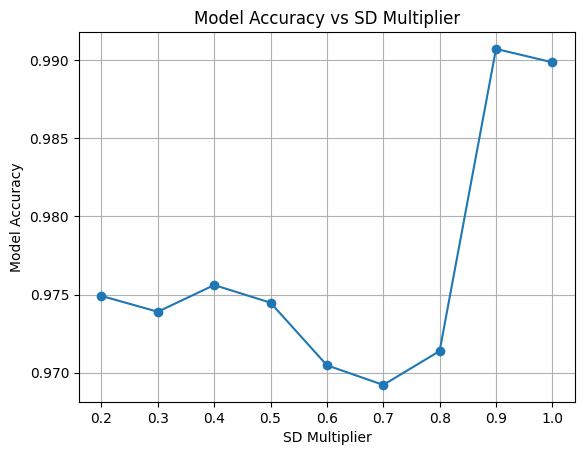

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming you have these imports and some functions (like create_windows) defined already

# Modify the cleaning function to accept the SD multiplier
def clean_within_group(group, sd_multiplier):
    for column in group.columns:
        if column not in ["act", "id"]:  # Skip non-sensor columns
            mean = group[column].mean()
            std = group[column].std()
            mask = (group[column] > mean - sd_multiplier*std) & (group[column] < mean + sd_multiplier*std)
            group.loc[mask, column] = np.nan
    return group.dropna()

def get_model_accuracy_for_sd(dataset, sd_multiplier):
    # Clean data with the current SD multiplier
    df_cleaned_by_activity = dataset.groupby('act').apply(lambda group: clean_within_group(group, sd_multiplier)).reset_index(drop=True)
    data_with_labels = np.c_[df_cleaned_by_activity.drop(columns=['act']).values, pd.factorize(df_cleaned_by_activity['act'])[0]]

    X, y = create_windows(data_with_labels, window_size=50, step_size=1)
    y = pd.get_dummies(y).values
    X_reduced = np.array([StandardScaler().fit_transform(window) for window in X])
    X_reduced = np.expand_dims(X_reduced, axis=3)  # Add a channel dimension

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=test_size, random_state=random_state)

    # Build Model
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy',
              metrics=['accuracy'])

    # Train
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    # Evaluate
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

# Loop through SD multipliers and get model accuracy for each
sd_multipliers = np.arange(0.2, 1.1, 0.1)
accuracies = [get_model_accuracy_for_sd(dataset, sd_multiplier) for sd_multiplier in sd_multipliers]

# Plot
plt.plot(sd_multipliers, accuracies, marker='o')
plt.xlabel('SD Multiplier')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy vs SD Multiplier')
plt.grid(True)
plt.show()


In [ ]:
dataset = pd.read_csv('clean.csv')

# Function to clean data within each activity group
def clean_within_group(group):
    for column in group.columns:
        if column not in ["act", "id"]:  # Skip non-sensor columns
            mean = group[column].mean()
            std = group[column].std()
            mask = (group[column] > mean - 0.4*std) & (group[column] < mean + 0.4*std)
            group.loc[mask, column] = np.nan
    return group.dropna()

# Apply the cleaning function to each activity group
df_cleaned_by_activity = dataset.groupby('act').apply(clean_within_group).reset_index(drop=True)

df_cleaned_by_activity


,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
0,-3.073846,3.196258,-1.527009,0.434857,0.520213,-0.468112,0.0,0.0
1,-2.689446,0.650326,-0.814967,0.481304,0.394734,-0.548130,0.0,0.0
2,-0.975081,2.029278,-0.823987,-0.365612,0.436940,0.579142,0.0,0.0
3,-0.720561,1.708834,-0.563289,-0.382505,1.362684,0.657322,0.0,0.0
4,-2.658740,1.446591,-0.435463,-0.251208,-0.195225,-0.141632,0.0,0.0
...,...,...,...,...,...,...,...,...
91669,-0.203768,0.211825,0.169621,-0.019496,0.046027,0.034358,5.0,23.0
91670,-0.305307,0.155780,0.154028,-0.016344,0.052892,0.024053,5.0,23.0
91671,-0.066291,0.071160,0.062871,-0.013911,-0.031781,-0.040557,5.0,23.0
91672,-0.044711,0.108421,0.053325,0.014741,0.015783,0.011358,5.0,23.0


<ipython-input-90-5c97d6764d10>:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(x_accel, y_accel, z_accel, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
<ipython-input-90-5c97d6764d10>:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(x_rotate, y_rotate, z_rotate, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)


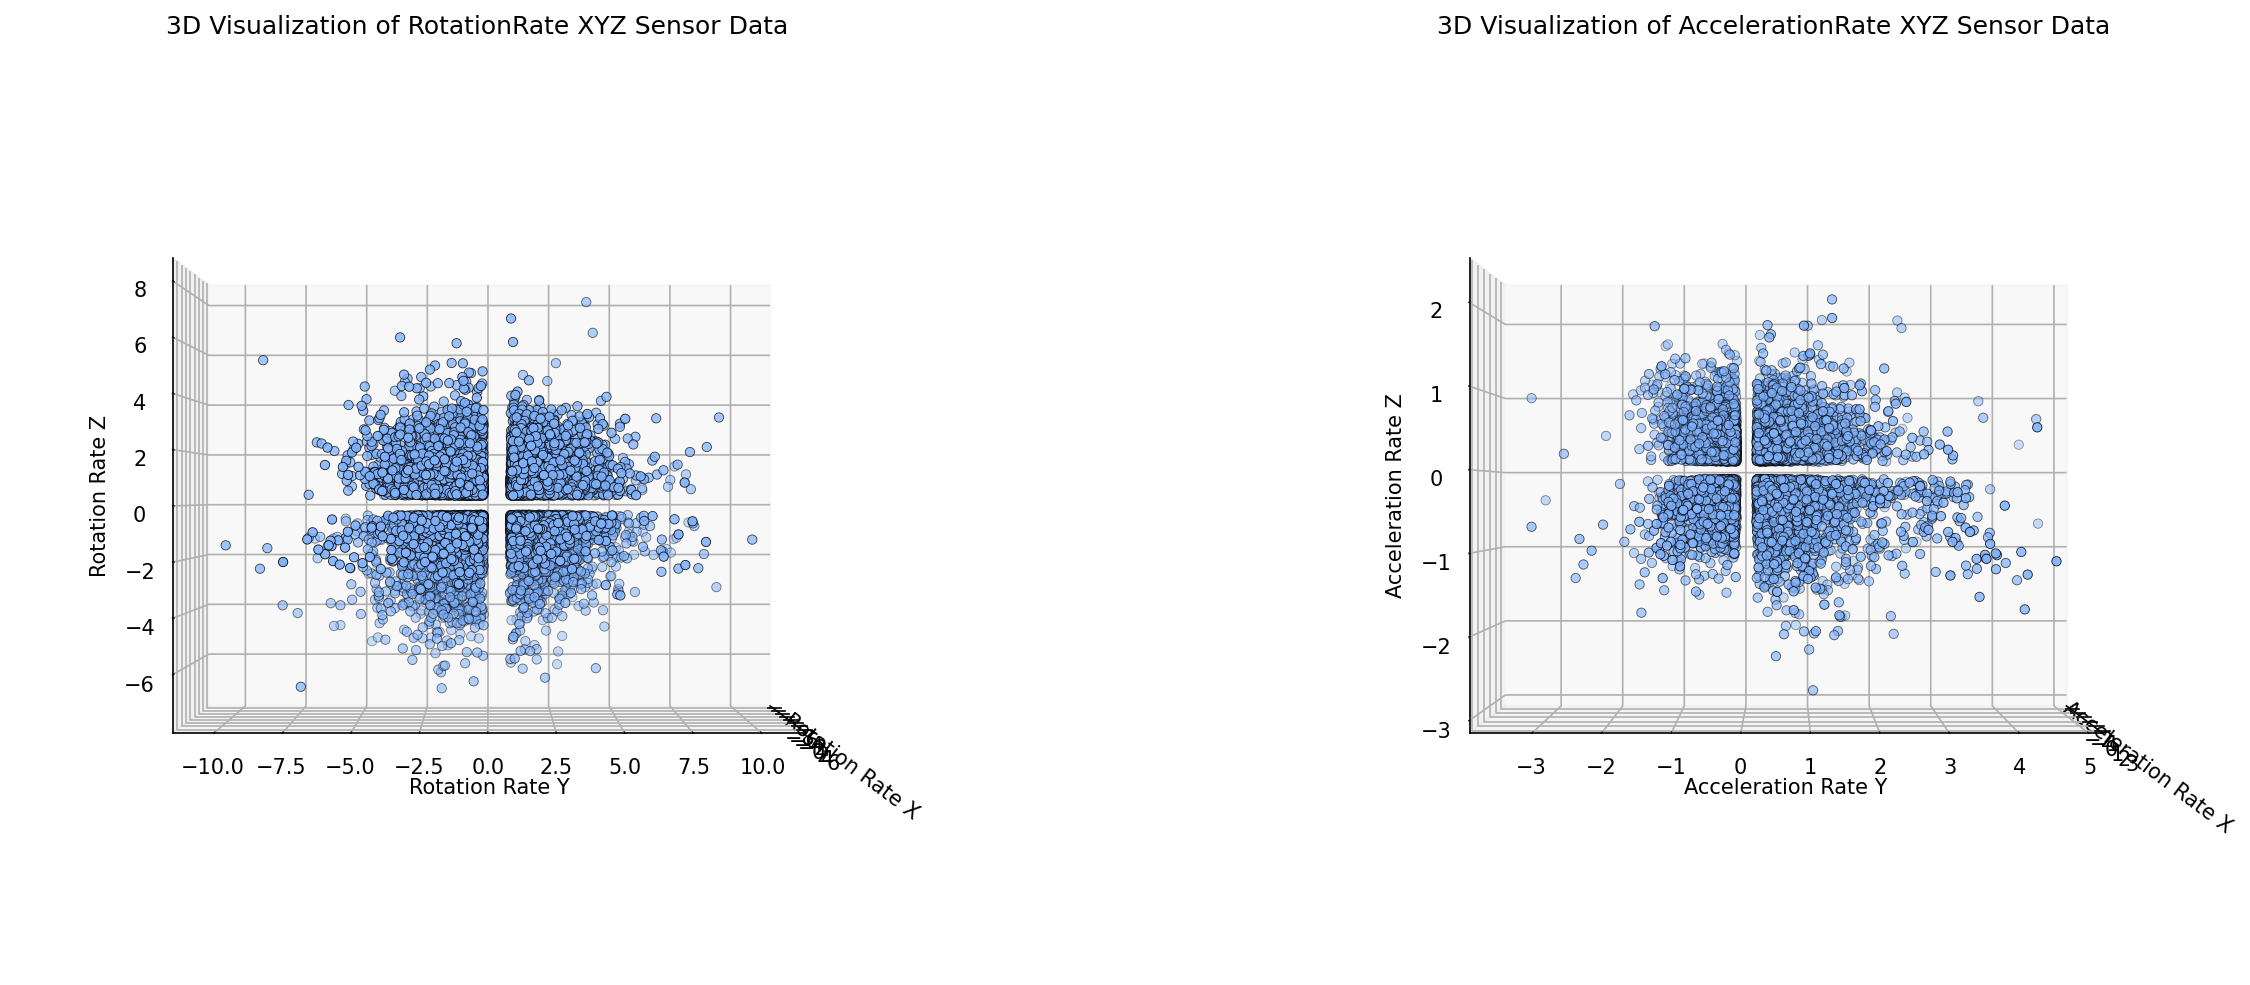

In [ ]:
#activity_1_data = df_cleaned_by_activity[(df_cleaned_by_activity['act'] == 1) & (df_cleaned_by_activity['id'] == 0)]
activity_1_data = df_cleaned_by_activity[(df_cleaned_by_activity['act'] == 1)]

# Extracting the rotationRate sensor data
x_rotate = activity_1_data["rotationRate.x"].dropna()
y_rotate = activity_1_data["rotationRate.y"].dropna()
z_rotate = activity_1_data["rotationRate.z"].dropna()

# Extracting the accelerationRate sensor data
x_accel = activity_1_data["userAcceleration.x"].dropna()
y_accel = activity_1_data["userAcceleration.y"].dropna()
z_accel = activity_1_data["userAcceleration.z"].dropna()

# Creating a 1x2 grid for the 3D scatter plots
fig = plt.figure(figsize=(20, 8), dpi = 150)

# Second plot: accelerationRate data
ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(x_accel, y_accel, z_accel, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
ax1.set_xlabel('Acceleration Rate X')
ax1.set_ylabel('Acceleration Rate Y')
ax1.set_zlabel('Acceleration Rate Z')
ax1.set_title('3D Visualization of AccelerationRate XYZ Sensor Data')

# First plot: rotationRate data
ax2 = fig.add_subplot(121, projection='3d')
ax2.scatter(x_rotate, y_rotate, z_rotate, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
ax2.set_xlabel('Rotation Rate X')
ax2.set_ylabel('Rotation Rate Y')
ax2.set_zlabel('Rotation Rate Z')
ax2.set_title('3D Visualization of RotationRate XYZ Sensor Data')

# Adjusting the viewpoint to face the origin for AccelerationRate data
ax1.view_init(elev=0, azim=0)

# Adjusting the viewpoint to face the origin for RotationRate data
ax2.view_init(elev=0, azim=0)

# Adjusting the spacing and margins
plt.subplots_adjust(wspace=0.1, right=0.95)
plt.show()

In [13]:
dataset = pd.read_csv('clean.csv')

# Function to clean data within each activity group
def clean_within_group(group):
    for column in group.columns:
        if column not in ["act", "id"]:  # Skip non-sensor columns
            mean = group[column].mean()
            std = group[column].std()
            mask = (group[column] > mean - 0.4*std) & (group[column] < mean + 0.4*std)
            group.loc[mask, column] = np.nan
    return group.dropna()

# Apply the cleaning function to each activity group
df_cleaned_by_activity = dataset.groupby('act').apply(clean_within_group).reset_index(drop=True)

df_cleaned_by_activity


,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
0,-3.073846,3.196258,-1.527009,0.434857,0.520213,-0.468112,0.0,0.0
1,-2.689446,0.650326,-0.814967,0.481304,0.394734,-0.548130,0.0,0.0
2,-0.975081,2.029278,-0.823987,-0.365612,0.436940,0.579142,0.0,0.0
3,-0.720561,1.708834,-0.563289,-0.382505,1.362684,0.657322,0.0,0.0
4,-2.658740,1.446591,-0.435463,-0.251208,-0.195225,-0.141632,0.0,0.0
...,...,...,...,...,...,...,...,...
91669,-0.203768,0.211825,0.169621,-0.019496,0.046027,0.034358,5.0,23.0
91670,-0.305307,0.155780,0.154028,-0.016344,0.052892,0.024053,5.0,23.0
91671,-0.066291,0.071160,0.062871,-0.013911,-0.031781,-0.040557,5.0,23.0
91672,-0.044711,0.108421,0.053325,0.014741,0.015783,0.011358,5.0,23.0


In [ ]:
df_cleaned_by_activity = df_cleaned_by_activity.dropna()
df_cleaned_by_activity

,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
0,-3.073846,3.196258,-1.527009,0.434857,0.520213,-0.468112,0.0,0.0
1,-1.885921,4.789145,-0.739632,0.489769,0.521320,-0.314285,0.0,0.0
2,-3.899313,2.205019,-1.163966,0.417322,0.755336,-0.631971,0.0,0.0
3,1.312888,-2.016324,1.440415,0.510177,-0.419095,-0.920074,0.0,0.0
4,-2.773227,4.568966,-0.803544,0.993941,0.775950,-0.731619,0.0,0.0
...,...,...,...,...,...,...,...,...
12273,-0.296383,-0.135464,0.251672,0.136709,0.032007,0.022252,5.0,23.0
12274,-0.068602,-0.168560,0.338763,-0.042878,-0.033159,0.105745,5.0,23.0
12275,-0.203768,0.211825,0.169621,-0.019496,0.046027,0.034358,5.0,23.0
12276,-0.305307,0.155780,0.154028,-0.016344,0.052892,0.024053,5.0,23.0


In [ ]:
data_with_labels = np.c_[df_cleaned_by_activity.drop(columns=['act']).values,
                                pd.factorize(df_cleaned_by_activity['act'])[0]]

In [ ]:
X, y = create_windows(data_with_labels, window_size=50, step_size=1)

In [ ]:
y = pd.get_dummies(y).values

In [ ]:
X_reduced = np.array([StandardScaler().fit_transform(window) for window in X])

In [ ]:
X_reduced = np.expand_dims(X_reduced, axis=3)  # Add a channel dimension

In [ ]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [ ]:
test_size = 0.2
random_state = None
task='multi_class'
window_size=50
step_size=1
target='act'
task='multi_class'
positive_label=None
preprocess='standard'
test_size=0.2
random_state=None
epochs=10
batch_size=32
save_model=False

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=test_size, random_state=random_state)

# Build Model
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test

Epoch 1/10
245/245 [==============================] - 2s 4ms/step - loss: 1.2220 - accuracy: 0.4936 - val_loss: 0.8073 - val_accuracy: 0.6699
Epoch 2/10
245/245 [==============================] - 1s 4ms/step - loss: 0.6219 - accuracy: 0.7550 - val_loss: 0.4969 - val_accuracy: 0.8130
Epoch 3/10
245/245 [==============================] - 1s 4ms/step - loss: 0.3723 - accuracy: 0.8646 - val_loss: 0.3281 - val_accuracy: 0.8901
Epoch 4/10
245/245 [==============================] - 1s 4ms/step - loss: 0.2594 - accuracy: 0.9104 - val_loss: 0.2560 - val_accuracy: 0.9218
Epoch 5/10
245/245 [==============================] - 1s 4ms/step - loss: 0.1795 - accuracy: 0.9433 - val_loss: 0.1822 - val_accuracy: 0.9479
Epoch 6/10
245/245 [==============================] - 1s 4ms/step - loss: 0.1524 - accuracy: 0.9512 - val_loss: 0.1590 - val_accuracy: 0.9474
Epoch 7/10
245/245 [==============================] - 1s 4ms/step - loss: 0.1112 - accuracy: 0.9666 - val_loss: 0.1189 - val_accuracy: 0.9647
Epoch 

In [ ]:
class_report = classification_report(y_test_labels, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       379
           1       0.98      0.92      0.95       675
           2       0.94      1.00      0.97       950
           3       0.98      0.96      0.97       452
           4       0.98      0.96      0.97       866
           5       0.95      0.97      0.96       576

    accuracy                           0.96      3898
   macro avg       0.97      0.96      0.96      3898
weighted avg       0.96      0.96      0.96      3898



In [ ]:
def create_windows(data, window_size, step_size=1, with_label=True):
    """
    Create windows from a data matrix.
    data: The input data. The last column is assumed to be the label if with_label is True.
    window_size: The size of the sliding window.
    step_size: The step size of the sliding window.
    with_label: Whether the data contains a label column.
    """
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            # Take the mode (most common) label in the window as the label for this window
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

In [ ]:
# Filter out rows containing any NaN values
df_cleaned = dataset.dropna()

df_cleaned

,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
26,-3.073846,3.196258,-1.527009,0.434857,0.520213,-0.468112,0.0,0.0
27,-2.689446,0.650326,-0.814967,0.481304,0.394734,-0.548130,0.0,0.0
32,-0.975081,2.029278,-0.823987,-0.365612,0.436940,0.579142,0.0,0.0
33,-0.720561,1.708834,-0.563289,-0.382505,1.362684,0.657322,0.0,0.0
69,-2.374246,1.767496,-0.745808,0.442384,0.380701,-0.574979,0.0,0.0
...,...,...,...,...,...,...,...,...
1380169,1.076615,1.304711,0.815545,-0.710737,0.705093,0.455779,2.0,23.0
1380187,-1.690601,-0.791507,-1.372810,-1.070217,0.575507,0.522521,2.0,23.0
1380193,-0.830967,-2.878659,-3.643716,-0.607956,0.340710,0.232298,2.0,23.0
1380208,-1.070794,-6.389108,3.038694,-0.358090,1.016247,2.936684,2.0,23.0


In [ ]:
data_with_labels = np.c_[df_cleaned.drop(columns=['act']).values,
                                pd.factorize(df_cleaned['act'])[0]]

In [ ]:
df_cleaned.shape

(28989, 8)

In [ ]:
def create_windows(data, window_size, step_size=1, with_label=True):
    """
    Create windows from a data matrix.
    data: The input data. The last column is assumed to be the label if with_label is True.
    window_size: The size of the sliding window.
    step_size: The step size of the sliding window.
    with_label: Whether the data contains a label column.
    """
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            # Take the mode (most common) label in the window as the label for this window
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

In [ ]:
X, y = create_windows(data_with_labels, window_size=50, step_size=1)

In [ ]:
y = pd.get_dummies(y).values

In [ ]:
X_reduced = np.array([StandardScaler().fit_transform(window) for window in X])

In [ ]:
X_reduced = np.expand_dims(X_reduced, axis=3)  # Add a channel dimension

In [ ]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
test_size = 0.2
random_state = None
task='multi_class'
window_size=50
step_size=1
target='act'
task='multi_class'
positive_label=None
preprocess='standard'
test_size=0.2
random_state=None
epochs=30
batch_size=32
save_model=False

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=test_size, random_state=random_state)

# Build Model
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


579/579 [==============================] - 3s 4ms/step - loss: 0.4759 - accuracy: 0.8154 - val_loss: 0.2312 - val_accuracy: 0.9268
Epoch 2/30
579/579 [==============================] - 2s 3ms/step - loss: 0.1982 - accuracy: 0.9302 - val_loss: 0.1467 - val_accuracy: 0.9506
Epoch 3/30
579/579 [==============================] - 2s 3ms/step - loss: 0.1369 - accuracy: 0.9508 - val_loss: 0.0877 - val_accuracy: 0.9691
Epoch 4/30
579/579 [==============================] - 2s 3ms/step - loss: 0.1051 - accuracy: 0.9620 - val_loss: 0.0867 - val_accuracy: 0.9685
Epoch 5/30
579/579 [==============================] - 2s 3ms/step - loss: 0.0843 - accuracy: 0.9702 - val_loss: 0.0592 - val_accuracy: 0.9849
Epoch 6/30
579/579 [==============================] - 2s 3ms/step - loss: 0.0671 - accuracy: 0.9760 - val_loss: 0.0399 - val_accuracy: 0.9883
Epoch 7/30
579/579 [==============================] - 2s 3ms/step - loss: 0.0637 - accuracy: 0.9765 - val_loss: 0.0643 - val_accuracy: 0.9754
Epoch 8/30
579/57

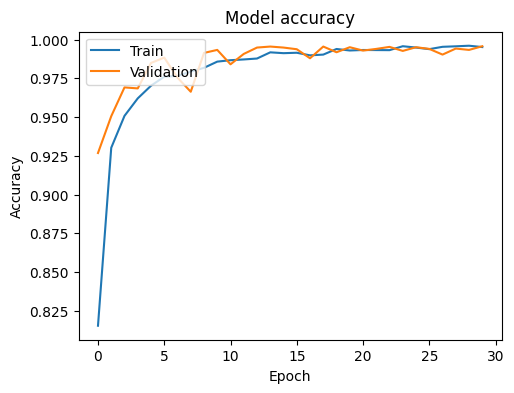

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


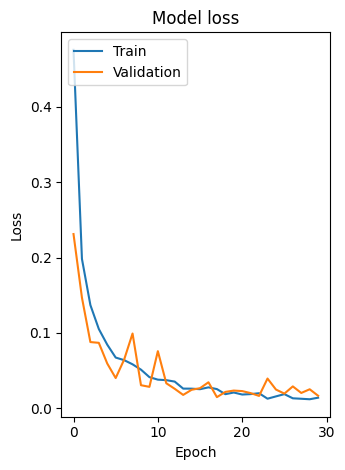

In [ ]:
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
dataset.shape

(1412865, 8)

573/573 [==============================] - 1s 2ms/step
Accuracy: 0.9815006821282402
Confusion Matrix: 
[[1975   26    2   11    5    0]
 [  29 2896    9    7   14    1]
 [   6   13 6247   21    3    0]
 [   4    2    0 2562    0    0]
 [   3    3    0    0 2951   15]
 [   9    5    0    0  151 1355]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2019
           1       0.98      0.98      0.98      2956
           2       1.00      0.99      1.00      6290
           3       0.99      1.00      0.99      2568
           4       0.94      0.99      0.97      2972
           5       0.99      0.89      0.94      1520

    accuracy                           0.98     18325
   macro avg       0.98      0.97      0.98     18325
weighted avg       0.98      0.98      0.98     18325



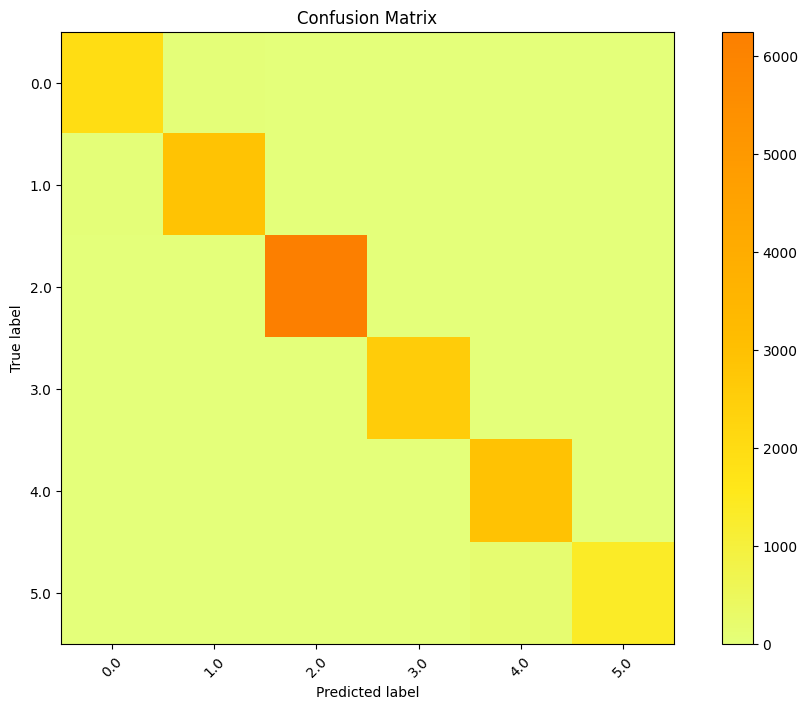

In [ ]:
# Evaluate again
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test

acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
conf_mat = confusion_matrix(y_test_labels, y_pred)
class_report = classification_report(y_test_labels, y_pred)

print(f"Accuracy: {acc}")
print("Confusion Matrix: ")
print(conf_mat)
print("Classification Report: ")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(dataset[target].unique()))
plt.xticks(tick_marks, dataset[target].unique(), rotation=45)
plt.yticks(tick_marks, dataset[target].unique())
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Extracting the sensor data
x = df_cleaned["rotationRate.x"].dropna()
y = df_cleaned["rotationRate.y"].dropna()
z = df_cleaned["rotationRate.z"].dropna()

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')

# Setting labels
ax.set_xlabel('Rotation Rate X')
ax.set_ylabel('Rotation Rate Y')
ax.set_zlabel('Rotation Rate Z')
ax.set_title('3D Visualization of XYZ Sensor Data')

plt.show()

NameError: ignored

<ipython-input-44-d5fd6bf08beb>:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(x_accel, y_accel, z_accel, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
<ipython-input-44-d5fd6bf08beb>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(x_rotate, y_rotate, z_rotate, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)


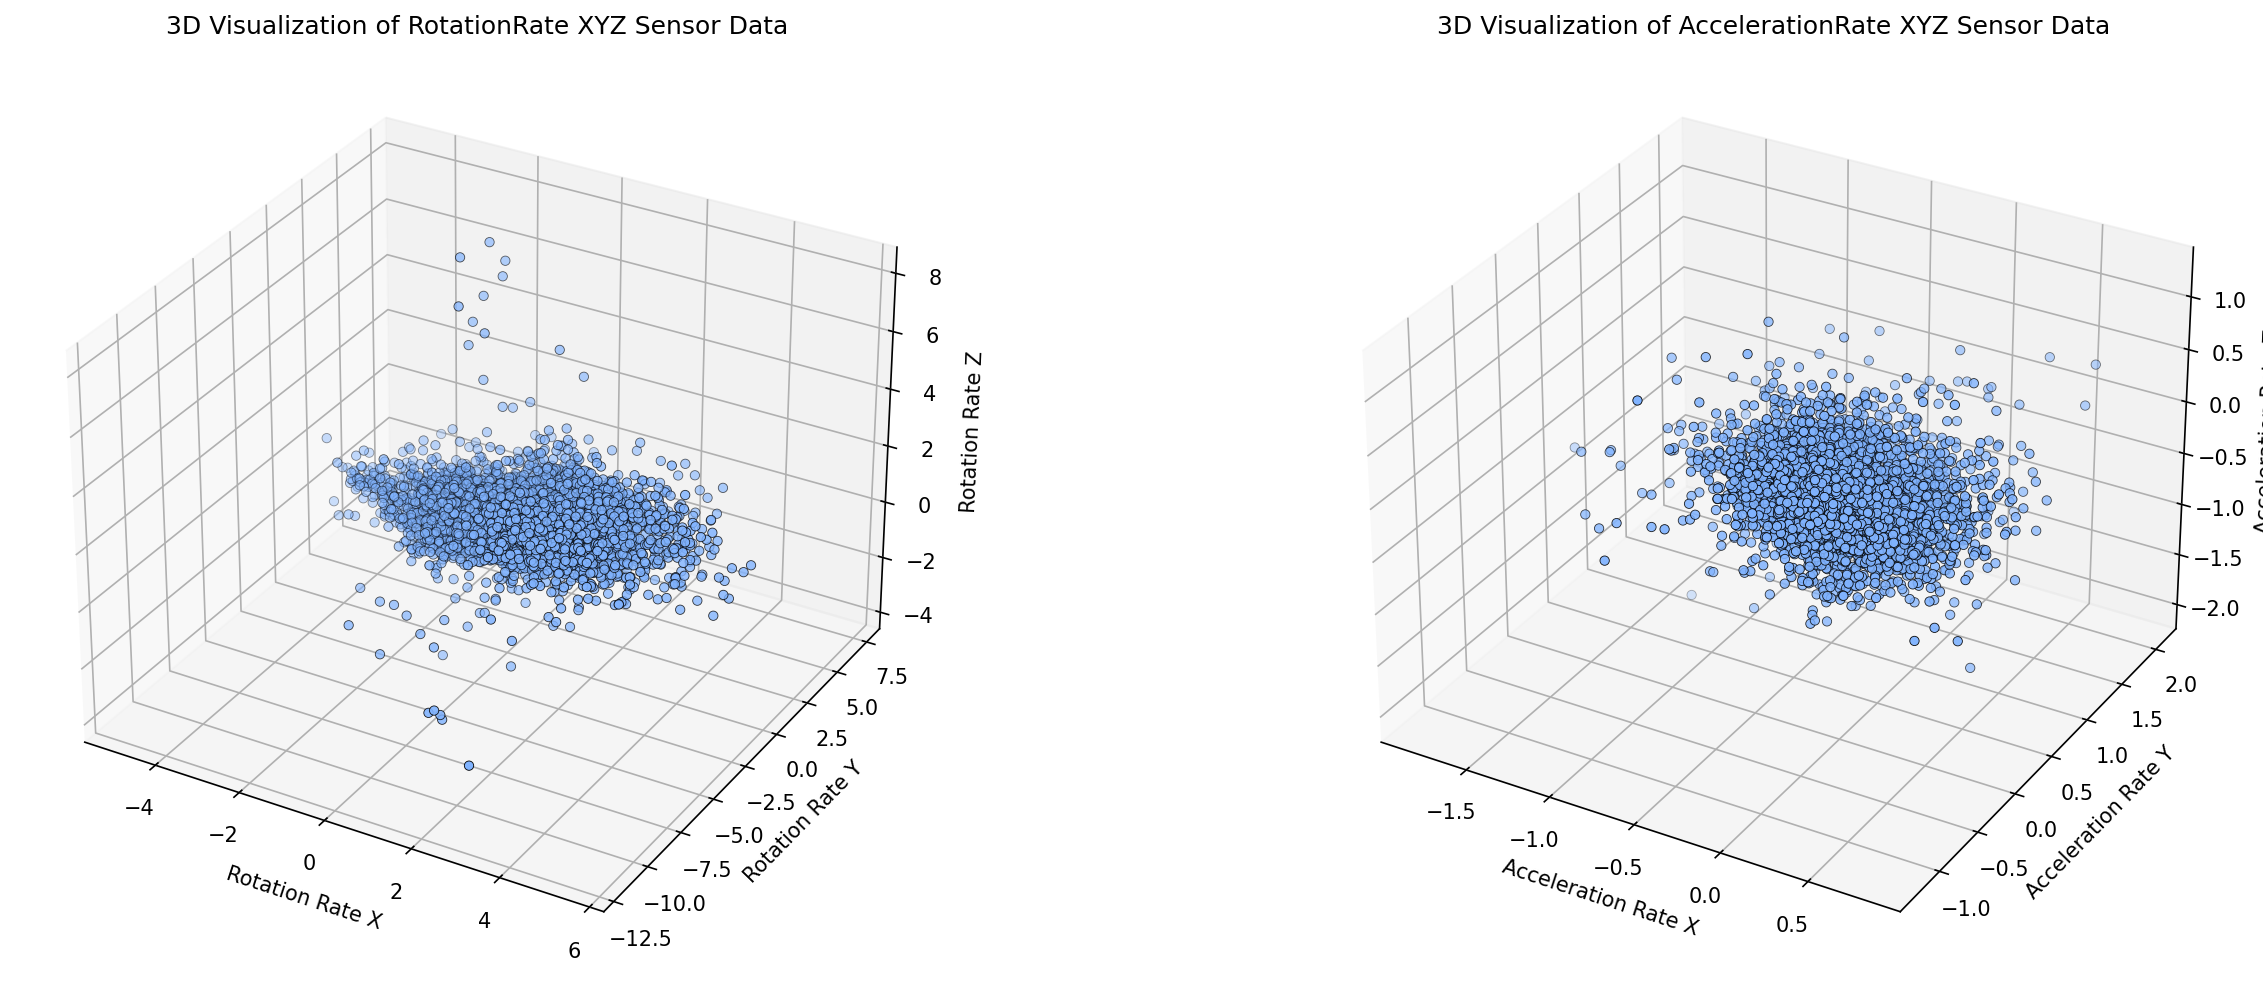

In [ ]:
activity_1_data = dat[(dat['act'] == 1) & (dat['id'] == 0)]

# Extracting the rotationRate sensor data
x_rotate = activity_1_data["rotationRate.x"].dropna()
y_rotate = activity_1_data["rotationRate.y"].dropna()
z_rotate = activity_1_data["rotationRate.z"].dropna()

# Extracting the accelerationRate sensor data
x_accel = activity_1_data["userAcceleration.x"].dropna()
y_accel = activity_1_data["userAcceleration.y"].dropna()
z_accel = activity_1_data["userAcceleration.z"].dropna()

# Creating a 1x2 grid for the 3D scatter plots
fig = plt.figure(figsize=(20, 8), dpi = 150)

# Second plot: accelerationRate data
ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(x_accel, y_accel, z_accel, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
ax1.set_xlabel('Acceleration Rate X')
ax1.set_ylabel('Acceleration Rate Y')
ax1.set_zlabel('Acceleration Rate Z')
ax1.set_title('3D Visualization of AccelerationRate XYZ Sensor Data')

# First plot: rotationRate data
ax2 = fig.add_subplot(121, projection='3d')
ax2.scatter(x_rotate, y_rotate, z_rotate, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
ax2.set_xlabel('Rotation Rate X')
ax2.set_ylabel('Rotation Rate Y')
ax2.set_zlabel('Rotation Rate Z')
ax2.set_title('3D Visualization of RotationRate XYZ Sensor Data')


# Adjusting the spacing and margins
plt.subplots_adjust(wspace=0.1, right=0.95)
plt.show()



<ipython-input-11-fbccd1c0bf3d>:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(x_accel, y_accel, z_accel, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
<ipython-input-11-fbccd1c0bf3d>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(x_rotate, y_rotate, z_rotate, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)


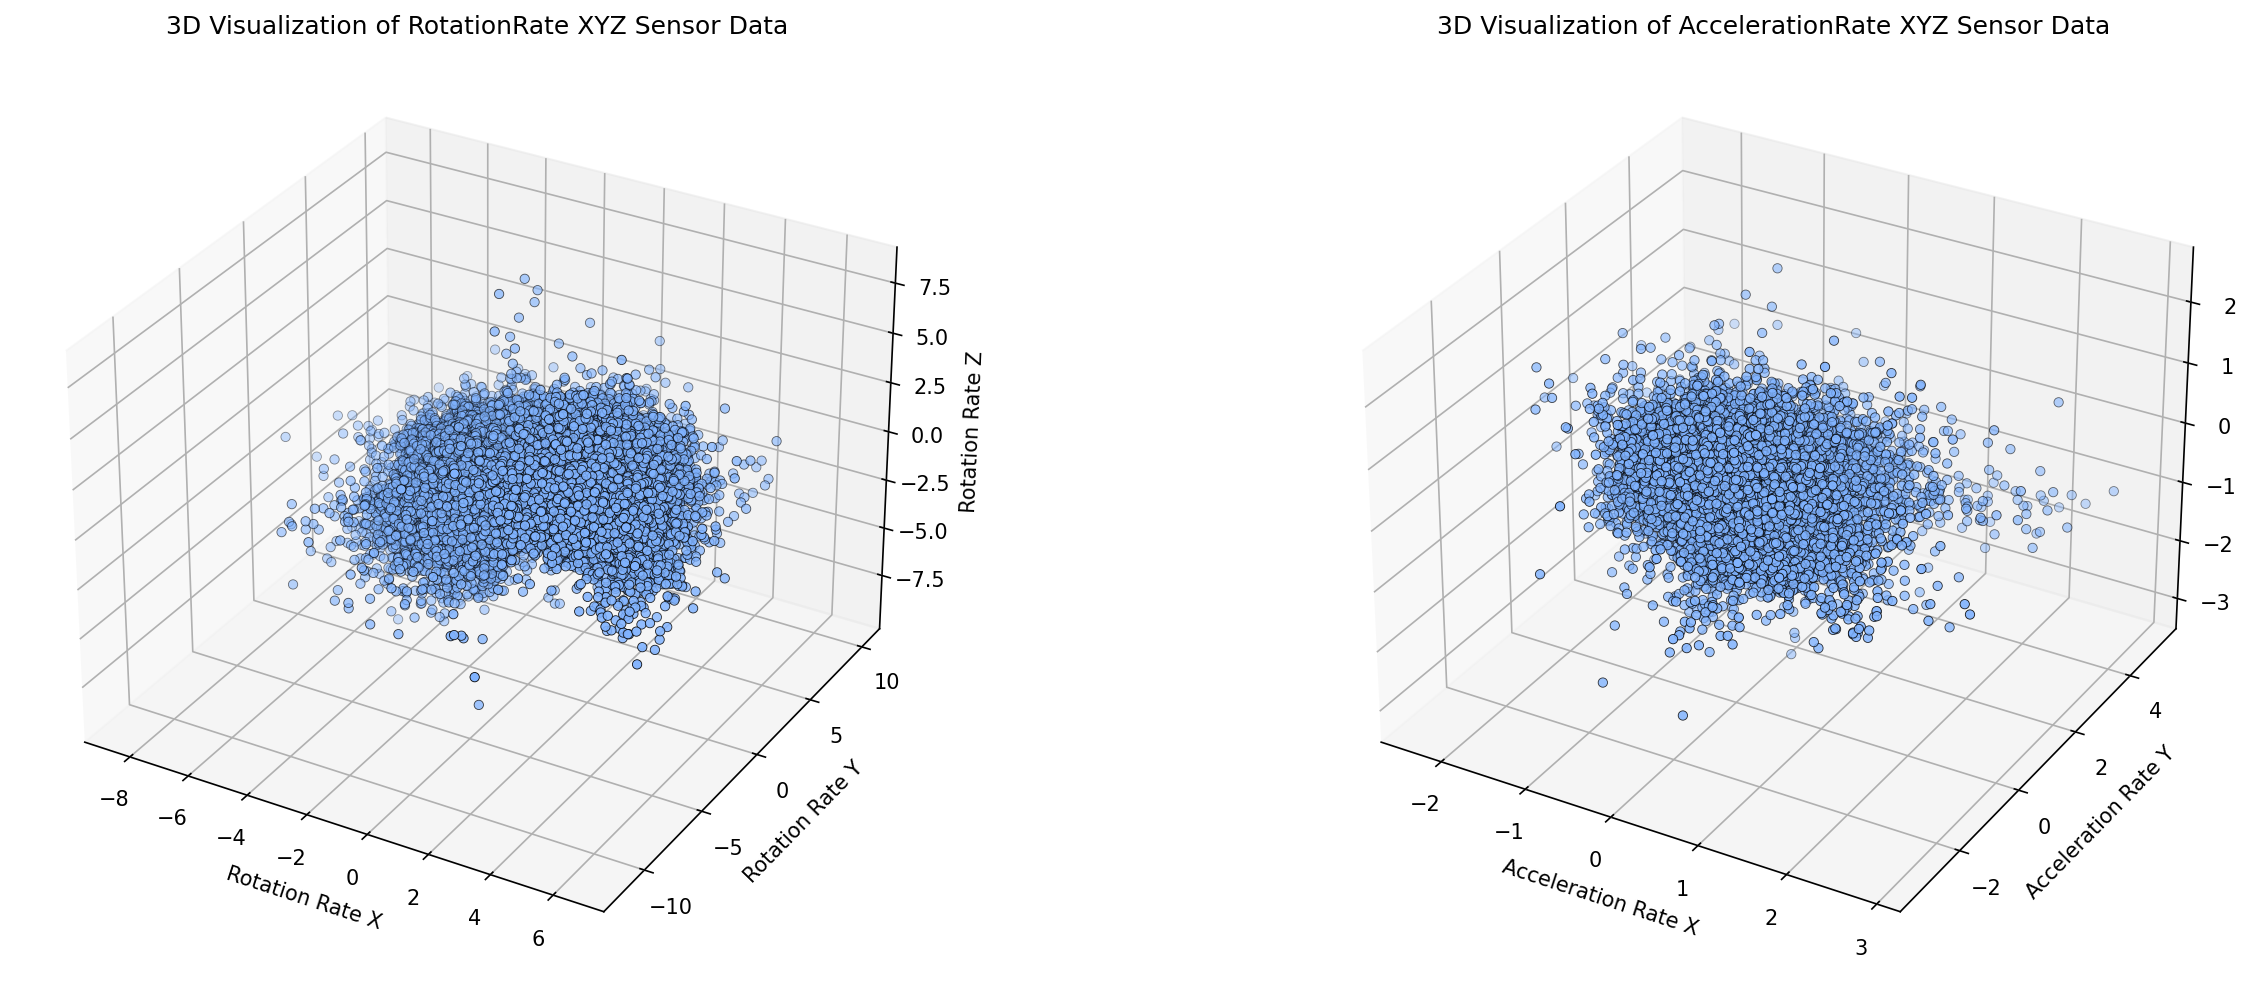

In [11]:
activity_1_data = dat[(dat['act'] == 1)]

# Extracting the rotationRate sensor data
x_rotate = activity_1_data["rotationRate.x"].dropna()
y_rotate = activity_1_data["rotationRate.y"].dropna()
z_rotate = activity_1_data["rotationRate.z"].dropna()

# Extracting the accelerationRate sensor data
x_accel = activity_1_data["userAcceleration.x"].dropna()
y_accel = activity_1_data["userAcceleration.y"].dropna()
z_accel = activity_1_data["userAcceleration.z"].dropna()

# Creating a 1x2 grid for the 3D scatter plots
fig = plt.figure(figsize=(20, 8), dpi = 150)

# Second plot: accelerationRate data
ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(x_accel, y_accel, z_accel, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
ax1.set_xlabel('Acceleration Rate X')
ax1.set_ylabel('Acceleration Rate Y')
ax1.set_zlabel('Acceleration Rate Z')
ax1.set_title('3D Visualization of AccelerationRate XYZ Sensor Data')

# First plot: rotationRate data
ax2 = fig.add_subplot(121, projection='3d')
ax2.scatter(x_rotate, y_rotate, z_rotate, c=(0.5, 0.7, 1.0), marker='o', edgecolors='black', linewidths=0.4)
ax2.set_xlabel('Rotation Rate X')
ax2.set_ylabel('Rotation Rate Y')
ax2.set_zlabel('Rotation Rate Z')
ax2.set_title('3D Visualization of RotationRate XYZ Sensor Data')


# Adjusting the spacing and margins
plt.subplots_adjust(wspace=0.1, right=0.95)
plt.show()


In [ ]:
activity_1_data

,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
0,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0
1,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0
2,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0
3,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0
4,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0
...,...,...,...,...,...,...,...,...
1365402,-0.801484,0.265616,-0.713091,-0.643846,1.073205,-0.381742,0.0,23.0
1365403,0.428794,-0.052029,0.132327,-0.249696,0.752001,-0.485723,0.0,23.0
1365404,1.276838,-0.846056,0.561216,0.384208,-0.491243,-0.411753,0.0,23.0
1365405,2.451713,-0.787113,1.052183,0.262480,-0.774967,-0.241872,0.0,23.0


In [ ]:
from matplotlib.animation import FuncAnimation

# Subset the data for activity 0
activity_0_data = df_cleaned[df_cleaned['act'] == 0]

# Extracting the sensor data for activity 0
x_activity_0 = activity_0_data["rotationRate.x"]
y_activity_0 = activity_0_data["rotationRate.y"]
z_activity_0 = activity_0_data["rotationRate.z"]

def update(num):
    ax.view_init(30, num)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_activity_0, y_activity_0, z_activity_0, c='b', marker='o')

# Setting labels
ax.set_xlabel('Rotation Rate X')
ax.set_ylabel('Rotation Rate Y')
ax.set_zlabel('Rotation Rate Z')
ax.set_title('3D Visualization of XYZ Sensor Data for Activity 0')

from IPython.display import HTML

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_activity_0, y_activity_0, z_activity_0, c='b', marker='o')

# Setting labels
ax.set_xlabel('Rotation Rate X')
ax.set_ylabel('Rotation Rate Y')
ax.set_zlabel('Rotation Rate Z')
ax.set_title('3D Visualization of XYZ Sensor Data for Activity 0')

# Creating the animation
ani = FuncAnimation(fig, update, frames=range(0,180), interval=50)

# Display the animation inline
HTML(ani.to_jshtml())



Output hidden; open in https://colab.research.google.com to view.

In [ ]:

!pip install ipympl

In [ ]:
#%matplotlib widget
%matplotlib inline

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
activity_0_data = df_cleaned_by_activity[df_cleaned_by_activity['act'] == 0]

# Extracting the sensor data for activity 0
x_activity_0 = activity_0_data["rotationRate.x"]
y_activity_0 = activity_0_data["rotationRate.y"]
z_activity_0 = activity_0_data["rotationRate.z"]

# Calculate means for each axis
mean_x = x_activity_0.mean()
mean_y = y_activity_0.mean()
mean_z = z_activity_0.mean()

# Determine quadrant for each point based on means
colors = []
for xi, yi, zi in zip(x_activity_0, y_activity_0, z_activity_0):
    if xi > mean_x:
        if yi > mean_y:
            if zi > mean_z:
                colors.append('red')    # Quadrant 1
            else:
                colors.append('green')  # Quadrant 2
        else:
            if zi > mean_z:
                colors.append('blue')   # Quadrant 3
            else:
                colors.append('yellow') # Quadrant 4
    else:
        if yi > mean_y:
            if zi > mean_z:
                colors.append('cyan')   # Quadrant 5
            else:
                colors.append('magenta')# Quadrant 6
        else:
            if zi > mean_z:
                colors.append('orange') # Quadrant 7
            else:
                colors.append('purple') # Quadrant 8

# Plotting with colors for each quadrant
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_activity_0, y_activity_0, z_activity_0, c=colors, marker='o')

# Setting labels and title
ax.set_xlabel('Rotation Rate X')
ax.set_ylabel('Rotation Rate Y')
ax.set_zlabel('Rotation Rate Z')
ax.set_title('3D Visualization of XYZ Sensor Data for Activity 0 with Quadrants')

plt.show()


# Creating the animation
ani = FuncAnimation(fig, update, frames=range(0,180), interval=50)

# Display the animation inline
HTML(ani.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

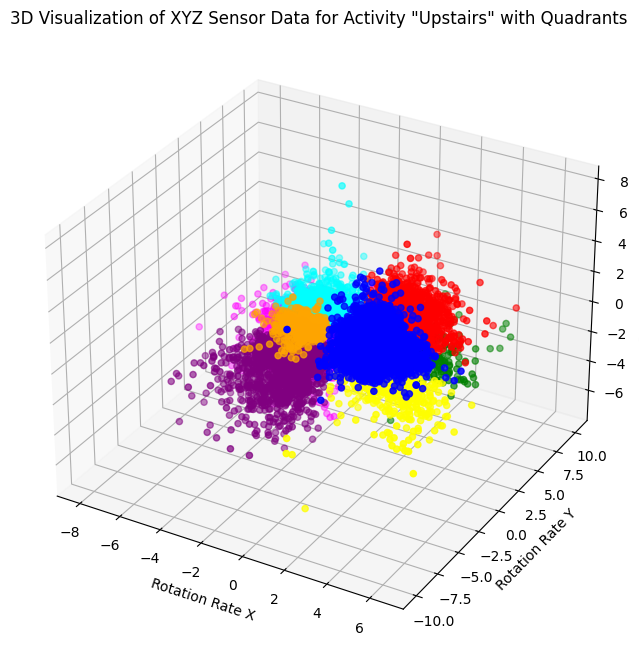

In [15]:
activity_0_data = df_cleaned_by_activity[df_cleaned_by_activity['act'] == 1]

# Extracting the sensor data for activity 0
x_activity_0 = activity_0_data["rotationRate.x"]
y_activity_0 = activity_0_data["rotationRate.y"]
z_activity_0 = activity_0_data["rotationRate.z"]

# Calculate means for each axis
mean_x = x_activity_0.mean()
mean_y = y_activity_0.mean()
mean_z = z_activity_0.mean()

# Determine quadrant for each point based on means
colors = []
for xi, yi, zi in zip(x_activity_0, y_activity_0, z_activity_0):
    if xi > mean_x:
        if yi > mean_y:
            if zi > mean_z:
                colors.append('red')    # Quadrant 1
            else:
                colors.append('green')  # Quadrant 2
        else:
            if zi > mean_z:
                colors.append('blue')   # Quadrant 3
            else:
                colors.append('yellow') # Quadrant 4
    else:
        if yi > mean_y:
            if zi > mean_z:
                colors.append('cyan')   # Quadrant 5
            else:
                colors.append('magenta')# Quadrant 6
        else:
            if zi > mean_z:
                colors.append('orange') # Quadrant 7
            else:
                colors.append('purple') # Quadrant 8

# Plotting with colors for each quadrant
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_activity_0, y_activity_0, z_activity_0, c=colors, marker='o')

# Setting labels and title
ax.set_xlabel('Rotation Rate X')
ax.set_ylabel('Rotation Rate Y')
ax.set_zlabel('Rotation Rate Z')
ax.set_title('3D Visualization of XYZ Sensor Data for Activity "Upstairs" with Quadrants')

plt.show()

In [ ]:
# Plotting the 3D scatter plot without animation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_activity_0, y_activity_0, z_activity_0, c=quadrant_colors, marker='o', depthshade=True)

# Draw lines for the means
ax.axvline(x=mean_x, color='k', linestyle='--')
ax.axhline(y=mean_y, color='k', linestyle='--')
ax.axvspan(mean_x, ax.get_xlim()[1], color='lightgray', alpha=0.1, zorder=-1)
ax.axhspan(mean_y, ax.get_ylim()[1], color='lightgray', alpha=0.1, zorder=-1)

# Setting labels and title
ax.set_xlabel('Rotation Rate X')
ax.set_ylabel('Rotation Rate Y')
ax.set_zlabel('Rotation Rate Z')
ax.set_title('3D Visualization of XYZ Sensor Data for Activity 0 with Quadrants')

plt.show()


AttributeError: ignored

<Figure size 1000x800 with 1 Axes>

In [ ]:
def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act',
                               task='multi_class', positive_label=None, preprocess='standard',
                               test_size=0.2, random_state=None, epochs=10,
                               batch_size=32, save_model=False):


X = np.expand_dims(X, axis=3)  # Add a channel dimension

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Build Model
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

    # Evaluate again
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test

    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(dataset[target].unique()))
    plt.xticks(tick_marks, dataset[target].unique(), rotation=45)
    plt.yticks(tick_marks, dataset[target].unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(dataset[target].unique()):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Save Model
    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                 preprocess='standard', test_size=0.2,
                 random_state=42, epochs=10, batch_size=32,
                 save_model=True)
